# Projet 7 - Réalisez une analyse de sentiments grâce au Deep Learning

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Étudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## Partie 2 : Approches classiques de Machine Learning

Ce notebook implémente plusieurs modèles de **machine learning traditionnels pour la classification de sentiment des tweets**. Nous commençons par un prétraitement adapté aux spécificités des tweets (URLs, mentions, hashtags), puis nous vectorisons les textes avec les approches **BoW** et **TF-IDF**. Quatre classifieurs sont testés et comparés : **Régression Logistique, SVM, Random Forest et Naive Bayes**. Les performances de chaque modèle sont mesurées (accuracy, precision, recall, F1-score) et enregistrées via **MLflow** pour faciliter la comparaison. Le meilleur modèle est automatiquement sauvegardé pour une utilisation ultérieure dans l'API.

## 📝 Contexte

Dans le cadre de ma formation d'AI Engineer chez OpenClassrooms, ce projet s'inscrit dans un scénario professionnel où j'interviens en tant qu'ingénieur IA chez MIC (Marketing Intelligence Consulting), entreprise de conseil spécialisée en marketing digital.

Notre client, Air Paradis (compagnie aérienne), souhaite **anticiper les bad buzz sur les réseaux sociaux**. La mission consiste à développer un produit IA permettant de **prédire le sentiment associé à un tweet**, afin d'améliorer la gestion de sa réputation en ligne.

## ⚡ Mission

> Développer un modèle d'IA permettant de prédire le sentiment associé à un tweet.

Créer un prototype fonctionnel d'un modèle d'**analyse de sentiments pour tweets** selon trois approches différentes :

1. **Modèle sur mesure simple** : Approche classique (régression logistique) pour une prédiction rapide
2. **Modèle sur mesure avancé** : Utilisation de réseaux de neurones profonds avec différents word embeddings
3. **Modèle avancé BERT** : Exploration de l'apport en performance d'un modèle BERT

Cette mission implique également la mise en œuvre d'une démarche MLOps complète :
- Utilisation de MLFlow pour le tracking des expérimentations et le stockage des modèles
- Création d'un pipeline de déploiement continu (Git + Github + plateforme Cloud)
- Intégration de tests unitaires automatisés
- Mise en place d'un suivi de performance en production via Azure Application Insight

## 🗓️ Plan de travail

1. **Exploration et préparation des données**
   - Acquisition des données de tweets Open Source
   - Analyse exploratoire et prétraitement des textes

2. **Développement des modèles**
   - Implémentation du modèle classique (régression logistique)
   - Conception du modèle avancé avec différents word embeddings
   - Test du modèle BERT pour l'analyse de sentiments
   - Comparaison des performances via MLFlow

3. **Mise en place de la démarche MLOps**
   - Configuration de MLFlow pour le tracking des expérimentations
   - Création du dépôt Git avec structure de projet appropriée
   - Implémentation des tests unitaires automatisés
   - Configuration du pipeline de déploiement continu

4. **Déploiement et monitoring**
   - Développement de l'API de prédiction avec FastAPI
   - Déploiement sur Heroku
   - Création de l'interface de test (Streamlit ou Next.js)
   - Configuration du suivi via Azure Application Insight

5. **Communication**
   - Rédaction de l'article de blog
   - Préparation du support de présentation

## Importation des bibliothèques

In [1]:
# Importations nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
import warnings
from collections import Counter
import pickle
from tqdm import tqdm

# Importations NLTK
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Importations scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             fbeta_score, make_scorer, matthews_corrcoef, balanced_accuracy_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)

# Configuration des visualisations
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /home/david/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 💾 Jeu de données : Sentiment140

Le jeu de données [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140) est une ressource majeure pour l'analyse de sentiment sur Twitter, comprenant **1,6 million de tweets** extraits via l'API Twitter. Ces tweets ont été automatiquement annotés selon leur polarité sentimentale, offrant une base solide pour développer des modèles de classification de sentiment.

Le jeu de données est organisé en 6 colonnes distinctes :

1. **target** : La polarité du sentiment exprimé dans le tweet.
   - 0 = sentiment négatif
   - 2 = sentiment neutre
   - 4 = sentiment positif
2. **ids** : L'identifiant unique du tweet (exemple : *2087*)
3. **date** : La date et l'heure de publication du tweet.
4. **flag** : La requête utilisée pour obtenir le tweet.
   - Exemple : *lyx*
   - Si aucune requête n'a été utilisée : *NO_QUERY*
5. **user** : Le nom d'utilisateur de l'auteur du tweet.
6. **text** : Le contenu textuel du tweet.

In [2]:
%%time 

# Define the URL and the local file path
url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip"
local_zip_path = "./content/data/sentiment140.zip"
extract_path = "./content/data"

if not os.path.exists(extract_path):

    # Create the directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)

    # Download the zip file
    response = requests.get(url)
    with open(local_zip_path, 'wb') as file:
        file.write(response.content)

    # Extract the contents of the zip file
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Delete the zip file
    os.remove(local_zip_path)

CPU times: user 62 μs, sys: 0 ns, total: 62 μs
Wall time: 66.3 μs


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

In [4]:

# Define the path to the CSV file
csv_file_path = os.path.join(extract_path, 'training.1600000.processed.noemoticon.csv')

# Define the column names
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Load the dataset into a pandas DataFrame
raw_data = pd.read_csv(csv_file_path, encoding='latin-1', names=column_names)

# Display the first few rows of the DataFrame
raw_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
print(f"Ce dataframe contient {raw_data.shape[0]} lignes et {raw_data.shape[1]} colonnes.")

Ce dataframe contient 1600000 lignes et 6 colonnes.


## Approches classiques de Machine Learning

Notre démarche pour la classification de sentiment avec des approches classiques comprend:

1. **Prétraitement des tweets**
   - Nettoyage
   - Tokenisation et lemmatisation
   - Remplacement des URLs et mentions par des tokens spéciaux

2. **Vectorisation du texte**
   - **Sac de mots (BoW)** : représentation basée sur la fréquence d'apparition
   - **TF-IDF** : pondération par importance relative des mots

3. **Modèles testés**
   - Régression Logistique: rapide et interprétable
   - SVM Linéaire: efficace pour les textes
   - Random Forest: robuste aux outliers
   - Naive Bayes: performant pour les classifications textuelles

4. **Évaluation et suivi**
   - Métriques: F2-score, F1-score, accuracy, précision, recall, ROC-AUC
   - Tracking avec MLflow pour la reproductibilité et la comparaison

In [6]:
def convert_sentiment_label(df):
    converted_target_data = df.copy()
    converted_target_data['target'] = converted_target_data['target'].apply(lambda x: 0 if x == 0 else 1)
    return converted_target_data

converted_target_data = convert_sentiment_label(raw_data)

In [7]:
converted_target_data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [8]:
def downsample_data(df, n_samples=50000):
    """
    Réduit la taille d'un DataFrame en échantillonnant aléatoirement un nombre spécifié de lignes pour chaque classe.
    """
    negative_samples = df[df['target'] == 0].sample(n=n_samples, random_state=42)
    positive_samples = df[df['target'] == 1].sample(n=n_samples, random_state=42)
    downsampled_data = pd.concat([negative_samples, positive_samples])
    return downsampled_data

downsampled_data = downsample_data(converted_target_data, n_samples=50000)
downsampled_data['target'].value_counts()

target
0    50000
1    50000
Name: count, dtype: int64

## Prétraitement

In [9]:
from multiprocessing import Pool

# Fonction de prétraitement pour les tweets
def preprocess_tweet(tweet):
    """
    Prétraite un tweet en appliquant plusieurs transformations :
    - Conversion en minuscules
    - Remplacement des URLs, mentions et hashtags par des tokens spéciaux
    - Suppression des caractères spéciaux
    - Tokenisation et lemmatisation
    - Suppression des stopwords
    """
    # Vérifier si le tweet est une chaîne de caractères
    if not isinstance(tweet, str):
        return ""
    
    # Convertir en minuscules
    tweet = tweet.lower()
    
    # Remplacer les URLs par un token spécial
    tweet = re.sub(r'https?://\S+|www\.\S+', '<URL>', tweet)
    
    # Remplacer les mentions par un token spécial
    tweet = re.sub(r'@\w+', '<MENTION>', tweet)
    
    # Traiter les hashtags (conserver le # comme token séparé et le mot qui suit)
    tweet = re.sub(r'#(\w+)', r'# \1', tweet)
    
    # Supprimer les caractères spéciaux et les nombres, mais garder les tokens spéciaux
    tweet = re.sub(r'[^\w\s<>@#!?]', '', tweet)
    
    # Tokenisation
    tokens = word_tokenize(tweet)
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Supprimer les stopwords, mais conserver les négations importantes
    stop_words = set(stopwords.words('english'))
    important_words = {'no', 'not', 'nor', 'neither', 'never', 'nobody', 'none', 'nothing', 'nowhere'}
    stop_words = stop_words - important_words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Rejoindre les tokens en une chaîne
    return ' '.join(tokens)


def process_in_parallel(df, func, n_jobs=4):
    """
    Applique une fonction à un DataFrame en le divisant en parties et en traitant chaque partie en parallèle.
    Permet d'accélérer le traitement sur les ordinateurs multi-coeurs.
    """
    df_split = np.array_split(df, n_jobs)
    pool = Pool(n_jobs)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def apply_preprocessing(df_part):
    df_part['processed_text'] = df_part['text'].apply(preprocess_tweet)
    return df_part

In [10]:
# Appliquer le prétraitement à tous les tweets
print("Prétraitement des tweets en cours...")
# downsampled_data['processed_text'] = downsampled_data['text'].apply(preprocess_tweet)
# Utilisation
preprocessed_data = process_in_parallel(downsampled_data, apply_preprocessing, n_jobs=8)
print("Prétraitement terminé !")

Prétraitement des tweets en cours...


Prétraitement terminé !


In [11]:
preprocessed_data.head()

,target,ids,date,flag,user,text,processed_text
212188,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,@xnausikaax oh no! where did u order from? tha...,< MENTION > oh no ! u order ? thats horrible
299036,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,A great hard training weekend is over. a coup...,great hard training weekend couple day rest le...
475978,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,"Right, off to work Only 5 hours to go until I...",right work 5 hour go im free xd
588988,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,I am craving for japanese food,craving japanese food
138859,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow got ta work...


## Division des données en ensembles d'entraînement et de test

In [12]:
# Diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

X = preprocessed_data['processed_text']
y = preprocessed_data['target']

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Taille de l'ensemble d'entraînement: {X_train.shape[0]} exemples")
print(f"Taille de l'ensemble de test: {X_test.shape[0]} exemples")

Taille de l'ensemble d'entraînement: 80000 exemples
Taille de l'ensemble de test: 20000 exemples


## Entraînement des modèles et tracking avec MLflow

### Configuration de MLFlow

In [13]:
import mlflow
from mlflow.models import infer_signature
from mlflow import MlflowClient
from dotenv import load_dotenv

# Charger les variables d'environnement depuis le fichier .env
load_dotenv()

# Configuration de MLflow avec les variables d'environnement
mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")

# Configuration explicite de MLflow
mlflow.set_tracking_uri(mlflow_tracking_uri)
print(f"MLflow Tracking URI: {mlflow_tracking_uri}")

# Configuration explicite des identifiants AWS
os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key
print("Identifiants AWS configurés")

MLflow Tracking URI: https://zany-orbit-q59ppqxj6j34j4x-5001.app.github.dev/
Identifiants AWS configurés


In [14]:
# Créer l'expérience MLflow
mlflow.set_experiment("OC Projet 7")

<Experiment: artifact_location='s3://mlflow-artefact-store/models/52', creation_time=1741945848821, experiment_id='52', last_update_time=1741945848821, lifecycle_stage='active', name='OC Projet 7', tags={}>

### Vectorisation des textes

La vectorisation est le processus qui transforme des documents textuels en vecteurs numériques exploitables par les algorithmes de machine learning. Les deux approches simples sont :

- **Bag of Words (BoW)** : compte simplement la fréquence d'apparition de chaque mot
- **TF-IDF** : pondère les mots selon leur importance (fréquence dans le document / fréquence dans tous les documents)

Ces méthodes créent des matrices généralement très creuses (>99% de zéros) car chaque document n'utilise qu'une petite partie du vocabulaire total. Dans notre implémentation, nous utilisons `CountVectorizer` pour l'approche BoW et `TfidfVectorizer` pour le TF-IDF, avec des n-grammes (1,2) qui permettent de capturer des expressions de deux mots consécutifs.


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Créer les vectoriseurs
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
bow_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2))


# Transformer les textes en vecteurs TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Transformer les textes en vecteurs BoW
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print("Vectorisation terminée !")

Vectorisation terminée !


### Fonction d'évaluation des modèles

Dans le contexte d'un outil préventif de **détection de bad buzz pour Air Paradis**, il est probablement plus important de **ne pas manquer de tweets négatifs** (priorité au rappel), nous pouvons considérer le **F2-score** qui donne plus de poids au rappel qu'à la précision.

In [16]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, vectorizer_name):
    """
    Évalue un modèle déjà entraîné et retourne les résultats
    """
    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)
    
    # Obtenir les probabilités ou scores de décision pour ROC AUC
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test)
    else:
        y_score = y_pred  # Fallback pour les modèles qui n'ont pas ces méthodes
    
    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)  # Ajout du F2-score
    roc_auc = roc_auc_score(y_test, y_score)
    
    # Créer la matrice de confusion sous forme de figure
    cm = confusion_matrix(y_test, y_pred)
    fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm)
    ax_cm.set_xlabel('Prédiction')
    ax_cm.set_ylabel('Valeur réelle')
    ax_cm.set_title(f'Matrice de confusion - {model_name} avec {vectorizer_name}')
    
    # Créer la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
    ax_roc.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('Taux de faux positifs')
    ax_roc.set_ylabel('Taux de vrais positifs')
    ax_roc.set_title(f'Courbe ROC - {model_name} avec {vectorizer_name}')
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True)
    
    # Afficher les résultats
    print(f"\nRésultats pour {model_name} avec {vectorizer_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")  # Ajout du F2-score
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nMatrice de confusion:")
    print(cm)
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred))
    
    return accuracy, precision, recall, f1, f2, roc_auc, fig_cm, fig_roc, y_pred

### Initialiser les modèles à tester

Voici la liste des modèles que nous allons tester :

- Régression Logistique
- SVM Linéaire
- Forêt Aléatoire
- Naive Bayes

In [17]:
# Initialiser les modèles à tester
base_models = {
    "Regression_Logistique": LogisticRegression(random_state=42),
    "SVM_Lineaire": LinearSVC(random_state=42),
    "Random_Forest": RandomForestClassifier(random_state=42),
    "Naive_Bayes": MultinomialNB()
}

# Définir les grilles d'hyperparamètres pour GridSearchCV
param_grids = {
    "Regression_Logistique": {
        'C': [0.01, 0.1, 1.0, 10.0],
        'max_iter': [1000],
        'solver': ['liblinear', 'saga']
    },
    "SVM_Lineaire": {
        'C': [0.01, 0.1, 1.0, 10.0],
        'max_iter': [1000],
        'dual': [True, False]
    },
    "Random_Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "Naive_Bayes": {
        'alpha': [0.1, 0.5, 1.0, 2.0]
    }
}

# Dictionnaire des vectoriseurs
vectorizers = {
    "TF-IDF": (tfidf_vectorizer, X_train_tfidf, X_test_tfidf),
    "BoW": (bow_vectorizer, X_train_bow, X_test_bow)
}

# Définir le scorer F2
scorers = {
    'f2': make_scorer(fbeta_score, beta=2),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
    'balanced_acc': make_scorer(balanced_accuracy_score)
}

## Entrainement des modèles

In [18]:
train_models = False

In [19]:
if train_models:

    # Tester chaque modèle avec les deux types de vectorisation
    total_iterations = len(base_models) * len(vectorizers)
    progress_bar = tqdm(total=total_iterations, desc="Progression globale")

    # Dictionnaire pour stocker les résultats
    results = []

    # Tester chaque modèle avec les deux types de vectorisation
    for model_name, base_model in base_models.items():
        for vectorizer_name, (vectorizer, X_train_vec, X_test_vec) in vectorizers.items():
            print(f"\n{'='*80}")
            print(f"Démarrage de GridSearchCV pour {model_name} avec {vectorizer_name}...")
            
            # Définir la grille de paramètres et créer GridSearchCV
            param_grid = param_grids[model_name]

            grid_search = GridSearchCV(
                base_model,
                param_grid,
                cv=5,
                scoring=scorers,
                refit='f2',
                n_jobs=-1,
                verbose=1,
                return_train_score=True
            )
            
            # Démarrer le run MLflow
            with mlflow.start_run(run_name=f"Modele_Simple_{model_name}_{vectorizer_name}"):
                # Journaliser les paramètres généraux
                mlflow.log_param("model_type", model_name)
                mlflow.log_param("vectorizer_type", vectorizer_name)
                mlflow.log_param("dataset_size", X_train.shape[0] + X_test.shape[0])
                mlflow.log_param("train_size", X_train.shape[0])
                mlflow.log_param("test_size", X_test.shape[0])
                mlflow.log_param("max_features", 10000)
                mlflow.log_param("ngram_range", "(1, 2)")
                mlflow.log_param("scoring_metric", "f2_score")  # Noter que F2 est utilisé
                
                # Mesurer le temps d'entraînement
                start_time = time.time()
                
                # Entraîner avec GridSearchCV
                grid_search.fit(X_train_vec, y_train)
                
                # Calculer le temps d'entraînement
                training_time = time.time() - start_time
                
                # Journaliser le temps d'entraînement
                mlflow.log_metric("training_time", training_time)
                
                # Récupérer et journaliser les meilleurs paramètres
                best_params = grid_search.best_params_
                for param, value in best_params.items():
                    mlflow.log_param(f"best_{param}", value)
                
                # Journaliser le meilleur score de validation croisée
                mlflow.log_metric("best_cv_f2_score", grid_search.best_score_)
                
                # Récupérer le meilleur modèle
                best_model = grid_search.best_estimator_
                
                # Évaluer le meilleur modèle sur l'ensemble de test
                acc, prec, rec, f1, f2, roc_auc, fig_cm, fig_roc, y_pred = evaluate_model(
                    best_model, X_train_vec, X_test_vec, y_train, y_test, model_name, vectorizer_name
                )
                
                # Journaliser les métriques
                mlflow.log_metric("accuracy", acc)
                mlflow.log_metric("precision", prec)
                mlflow.log_metric("recall", rec)
                mlflow.log_metric("f1", f1)
                mlflow.log_metric("f2", f2)
                mlflow.log_metric("roc_auc", roc_auc)
                
                # Journaliser les figures
                mlflow.log_figure(fig_cm, "confusion_matrix.png")
                mlflow.log_figure(fig_roc, "roc_curve.png")
                plt.close(fig_cm)
                plt.close(fig_roc)
                
                # Journaliser le modèle
                signature = infer_signature(X_train_vec, y_pred)
                mlflow.sklearn.log_model(best_model, "model", signature=signature)

                # Créer le dossier pour sauvegarder les artefacts
                os.makedirs("./content/simple-model", exist_ok=True)
                
                # Sauvegarder et journaliser le vectoriseur
                vectorizer_path = f"./content/simple-model/vectorizer_{vectorizer_name}.pkl"
                with open(vectorizer_path, "wb") as f:
                    pickle.dump(vectorizer, f)
                mlflow.log_artifact(vectorizer_path)
                
                # Journaliser les résultats détaillés de GridSearchCV
                cv_results = pd.DataFrame(grid_search.cv_results_)
                cv_results_path = "./content/simple-model/cv_results.csv"
                cv_results.to_csv(cv_results_path, index=False)
                mlflow.log_artifact(cv_results_path)
                
                # Créer et journaliser un graphique des résultats de GridSearchCV
                plt.figure(figsize=(12, 8))
                params = [f"{k}={v}" for k, v in best_params.items()]
                params_str = ", ".join(params)
                
                # Extraire les scores moyens pour chaque paramètre principal
                for param in param_grid.keys():
                    if len(param_grid[param]) > 1:  # Seulement si le paramètre a plusieurs valeurs
                        param_name = f"param_{param}"
                        if param_name in cv_results.columns:
                            # Utiliser la colonne spécifique à la métrique f2 (que vous avez définie comme principale)
                            scores_df = cv_results[[param_name, "mean_test_f2", "std_test_f2"]]
                            scores_df = scores_df.sort_values(param_name)
                            
                            plt.figure(figsize=(10, 6))
                            plt.errorbar(
                                scores_df[param_name].astype(str),
                                scores_df["mean_test_f2"],
                                yerr=scores_df["std_test_f2"],
                                fmt='-o'
                            )
                            plt.title(f'Scores de validation croisée (F2) par {param}')
                            plt.xlabel(param)
                            plt.ylabel('F2 Score moyen')
                            plt.grid(True)
                            mlflow.log_figure(plt.gcf(), f"cv_results_{param}.png")
                            plt.close()
                
                # Journaliser les features importantes (pour les modèles qui le supportent)
                if hasattr(best_model, 'coef_'):
                    # Récupérer les features les plus importantes
                    if isinstance(best_model, LogisticRegression) or isinstance(best_model, LinearSVC):
                        coefs = best_model.coef_[0]
                        if vectorizer_name == "TF-IDF":
                            feature_names = tfidf_vectorizer.get_feature_names_out()
                        else:
                            feature_names = bow_vectorizer.get_feature_names_out()
                        
                        # Créer un DataFrame avec les coefs et les noms des features
                        coefs_df = pd.DataFrame({
                            'feature': feature_names,
                            'importance': coefs
                        })
                        
                        # Trier par importance absolue
                        coefs_df['abs_importance'] = abs(coefs_df['importance'])
                        coefs_df = coefs_df.sort_values('abs_importance', ascending=False).head(20)
                        
                        # Journaliser les features les plus importantes
                        top_features_path = "./content/simple-model/top_features.csv"
                        coefs_df.to_csv(top_features_path, index=False)
                        mlflow.log_artifact(top_features_path)
                        
                        # Créer un graphique pour visualiser les features les plus importantes
                        plt.figure(figsize=(10, 8))
                        sns.barplot(x='importance', y='feature', data=coefs_df.sort_values('importance', ascending=False).head(20))
                        plt.title(f'Top 20 features positives')
                        plt.tight_layout()
                        mlflow.log_figure(plt.gcf(), "top_positive_features.png")
                        plt.close()
                        
                        plt.figure(figsize=(10, 8))
                        sns.barplot(x='importance', y='feature', data=coefs_df.sort_values('importance').head(20))
                        plt.title(f'Top 20 features négatives')
                        plt.tight_layout()
                        mlflow.log_figure(plt.gcf(), "top_negative_features.png")
                        plt.close()
                
                # Stocker les résultats pour comparaison
                results.append({
                    "Modèle": model_name.replace("_", " "),
                    "Vectorisation": vectorizer_name,
                    "Meilleurs paramètres": str(best_params),
                    "Accuracy": acc,
                    "Precision": prec,
                    "Recall": rec,
                    "F1 Score": f1,
                    "F2 Score": f2,
                    "ROC AUC": roc_auc,
                    "Temps d'entraînement (s)": training_time
                })
                
                # Afficher les résultats
                print(f"Meilleurs paramètres: {best_params}")
                print(f"Meilleur score CV (F2): {grid_search.best_score_:.4f}")
                print(f"F1 Score sur test: {f1:.4f}")
                print(f"F2 Score sur test: {f2:.4f}")
                print(f"ROC AUC sur test: {roc_auc:.4f}")
                print(f"Temps d'entraînement: {training_time:.2f} secondes")


            # À la fin de chaque itération, mettez à jour la barre de progression
            progress_bar.update(1)
            progress_bar.set_description(f"Dernier modèle: {model_name} avec {vectorizer_name}")

    progress_bar.close()

## Evaluation des performances

### Récupération des resultats depuis le serveur MLFLow

In [20]:
def get_mlflow_results(experiment_name="OC Projet 7", prefixe_run="Modele_Simple_", uri=None):
    """
    Récupère les résultats des runs MLflow et les organise dans un dataframe
    
    Parameters:
    -----------
    experiment_name : str
        Nom de l'expérience MLflow à rechercher
    prefixe_run : str
        Préfixe des noms de runs à inclure
    uri : str, optional
        URI du serveur MLflow. Si None, utilise l'URI configuré par défaut
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe contenant les résultats des runs MLflow
    """
    # Se connecter au serveur MLflow si un URI est fourni
    if uri:
        mlflow.set_tracking_uri(uri)
    
    # Créer un client MLflow
    client = MlflowClient()
    
    # Récupérer l'ID de l'expérience
    try:
        experiment = client.get_experiment_by_name(experiment_name)
        if experiment is None:
            raise ValueError(f"L'expérience '{experiment_name}' n'existe pas.")
        experiment_id = experiment.experiment_id
    except Exception as e:
        print(f"Erreur lors de la récupération de l'expérience : {e}")
        return pd.DataFrame()
    
    # Récupérer tous les runs de l'expérience
    runs = client.search_runs(
        experiment_ids=[experiment_id],
        filter_string=f"tags.mlflow.runName LIKE '{prefixe_run}%'",
        order_by=["metrics.f2 DESC"]
    )
    
    # Créer une liste pour stocker les résultats
    resultats = []
    
    # Parcourir chaque run et extraire les informations
    for run in runs:
        # Récupérer le nom du run pour information
        run_name = run.data.tags.get("mlflow.runName", "")
        
        # Utiliser les paramètres model_type et vectorizer_type de MLflow
        modele = run.data.params.get("model_type", "Inconnu")
        vectorisation = run.data.params.get("vectorizer_type", "Inconnu")
        
        # Formater le nom du modèle (remplacer les underscores par des espaces)
        modele = modele.replace("_", " ")
            
        # Extraire les métriques
        metrics = run.data.metrics
        params = run.data.params
        
        # Construire un dictionnaire des meilleurs paramètres
        best_params = {}
        for key, value in params.items():
            if key.startswith("best_"):
                param_name = key.replace("best_", "")
                best_params[param_name] = value
        
        # Créer une entrée pour le dataframe résultat
        resultats.append({
            "Modèle": modele,
            "Vectorisation": vectorisation,
            "Meilleurs paramètres": str(best_params),
            "Accuracy": metrics.get("accuracy", None),
            "Precision": metrics.get("precision", None),
            "Recall": metrics.get("recall", None),
            "F1 Score": metrics.get("f1", None),
            "F2 Score": metrics.get("f2", None),
            "ROC AUC": metrics.get("roc_auc", None),
            "Temps d'entraînement (s)": metrics.get("training_time", None),
            "Run ID": run.info.run_id,
            "Run Name": run_name
        })
    
    # Créer un dataframe à partir des résultats
    df_resultats = pd.DataFrame(resultats)
    
    # Trier le dataframe par F2 Score (décroissant)
    if not df_resultats.empty and "F2 Score" in df_resultats.columns:
        df_resultats = df_resultats.sort_values("F2 Score", ascending=False)
    
    return df_resultats

In [21]:
# Récupérer les résultats
results_df = get_mlflow_results(experiment_name="OC Projet 7", prefixe_run="Modele_Simple_")

### Sauvegarde des résultats

- Au format Markdown (.md)
- Au format CSV (.csv)

In [22]:
def export_results_to_markdown(df, output_file="content/simple-model/mlflow_results.md"):
    with open(output_file, "w") as f:
        f.write("# Résultats des expérimentations MLflow\n\n")
        f.write(df.to_markdown(index=False))

# Exporter les résultats au format Markdown
export_results_to_markdown(results_df)

In [23]:
results_path = "./content/simple-model/mlflow_results.csv"
# Enregistrer le tableau des résultats (optionnel)
results_df.to_csv(results_path, index=False)

### Visualisation des métriques

In [24]:
results_df

,Modèle,Vectorisation,Meilleurs paramètres,Accuracy,Precision,Recall,F1 Score,F2 Score,ROC AUC,Temps d'entraînement (s),Run ID,Run Name
0,SVM Lineaire,BoW,"{'C': '0.01', 'dual': 'True', 'max_iter': '1000'}",0.77955,0.765454,0.8061,0.785252,0.797629,0.851737,51.357372,82e7cbe6cb064cdba3d9fbff6cf2feb0,Modele_Simple_SVM_Lineaire_BoW
1,Regression Logistique,BoW,"{'max_iter': '1000', 'C': '0.1', 'solver': 'li...",0.77910,0.766622,0.8025,0.784151,0.795058,0.851555,111.731545,74cc24bac96a4b9f9e35d83bdf9d35f8,Modele_Simple_Regression_Logistique_BoW
2,SVM Lineaire,TF-IDF,"{'dual': 'True', 'C': '0.1', 'max_iter': '1000'}",0.78475,0.776537,0.7996,0.787900,0.794878,0.861595,15.387059,7ac11db18f3c417994f5fe2c0092fadd,Modele_Simple_SVM_Lineaire_TF-IDF
3,Regression Logistique,TF-IDF,"{'C': '1.0', 'max_iter': '1000', 'solver': 'sa...",0.78335,0.776466,0.7958,0.786014,0.791857,0.861383,11.372691,0506dbfb0afe4863aefbcdd412818ad6,Modele_Simple_Regression_Logistique_TF-IDF
4,Random Forest,BoW,"{'max_depth': '10', 'min_samples_split': '2', ...",0.71050,0.678571,0.7999,0.734257,0.772283,0.778970,1306.635550,091292a97be84353bcf425c492e3b1f3,Modele_Simple_Random_Forest_BoW
5,Random Forest,TF-IDF,"{'max_depth': 'None', 'min_samples_split': '5'...",0.76560,0.763231,0.7701,0.766650,0.768716,0.841652,1487.803808,bd3253dfc75c45f2b3ec118c2b6b957d,Modele_Simple_Random_Forest_TF-IDF
6,Naive Bayes,BoW,{'alpha': '2.0'},0.77120,0.775610,0.7632,0.769355,0.765650,0.843390,0.498161,ef4915f7062a45818fbea8d7cdf9aa2e,Modele_Simple_Naive_Bayes_BoW
7,Naive Bayes,TF-IDF,{'alpha': '2.0'},0.76970,0.776106,0.7581,0.766997,0.761634,0.851326,0.497247,efbd59c08de045d199e51813c5ebb404,Modele_Simple_Naive_Bayes_TF-IDF


In [25]:
def afficher_tableau_comparatif(df):
    """
    Affiche un tableau comparatif formaté des résultats
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe contenant les résultats à afficher
    """
    if df.empty:
        print("Aucun résultat à afficher.")
        return
    
    # Sélectionner et formater les colonnes pour l'affichage
    df_display = df[["Modèle", "Vectorisation", "Accuracy", "Precision", "Recall", 
                      "F1 Score", "F2 Score", "ROC AUC", "Temps d'entraînement (s)"]]
    
    # Formater les valeurs numériques
    for col in ["Accuracy", "Precision", "Recall", "F1 Score", "F2 Score", "ROC AUC"]:
        if col in df_display.columns:
            df_display[col] = df_display[col].apply(lambda x: f"{x:.4f}" if x is not None else "N/A")
    
    if "Temps d'entraînement (s)" in df_display.columns:
        df_display["Temps d'entraînement (s)"] = df_display["Temps d'entraînement (s)"].apply(
            lambda x: f"{x:.2f}" if x is not None else "N/A")
    
    # Afficher le tableau
    print("\n=== Comparaison des modèles ===\n")
    print(df_display.to_string(index=False))
    
    # Identifier le meilleur modèle selon le F2 Score
    if "F2 Score" in df.columns:
        best_idx = df["F2 Score"].idxmax() if not df.empty else None
        if best_idx is not None:
            best_model = df.loc[best_idx]
            print("\n=== Meilleur modèle ===")
            print(f"Modèle: {best_model['Modèle']}")
            print(f"Vectorisation: {best_model['Vectorisation']}")
            print(f"F2 Score: {best_model['F2 Score']:.4f}")
            print(f"Meilleurs paramètres: {best_model['Meilleurs paramètres']}")

In [26]:
# Afficher le tableau comparatif
afficher_tableau_comparatif(results_df)


=== Comparaison des modèles ===

               Modèle Vectorisation Accuracy Precision Recall F1 Score F2 Score ROC AUC Temps d'entraînement (s)
         SVM Lineaire           BoW   0.7795    0.7655 0.8061   0.7853   0.7976  0.8517                    51.36
Regression Logistique           BoW   0.7791    0.7666 0.8025   0.7842   0.7951  0.8516                   111.73
         SVM Lineaire        TF-IDF   0.7847    0.7765 0.7996   0.7879   0.7949  0.8616                    15.39
Regression Logistique        TF-IDF   0.7833    0.7765 0.7958   0.7860   0.7919  0.8614                    11.37
        Random Forest           BoW   0.7105    0.6786 0.7999   0.7343   0.7723  0.7790                  1306.64
        Random Forest        TF-IDF   0.7656    0.7632 0.7701   0.7667   0.7687  0.8417                  1487.80
          Naive Bayes           BoW   0.7712    0.7756 0.7632   0.7694   0.7657  0.8434                     0.50
          Naive Bayes        TF-IDF   0.7697    0.7761 0.7581 

In [27]:
def display_metrics_subplot(df, figsize=(18, 14)):
    """
    Génère des sous-graphiques pour visualiser toutes les métriques avec une échelle fixe (0,1)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame contenant les résultats des modèles avec leurs métriques
    figsize : tuple, optional
        Taille de la figure (largeur, hauteur)
    Returns:
    --------
    matplotlib.figure.Figure
        La figure générée
    """
    # Définir les métriques à visualiser
    metriques = ["Accuracy", "Precision", "Recall", "F1 Score", "F2 Score", "ROC AUC"]
    
    # Créer une figure avec des sous-graphiques
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    axes = axes.flatten()
    
    # Définir une palette de couleurs cohérente
    palette = sns.color_palette("Set2", len(df["Vectorisation"].unique()))
    
    # Créer un barplot pour chaque métrique
    for i, metrique in enumerate(metriques):
        ax = axes[i]
        
        # Créer le barplot
        sns.barplot(
            x="Modèle", 
            y=metrique, 
            hue="Vectorisation", 
            data=df,
            ax=ax,
            palette=palette
        )
        
        # Configurer l'axe y pour qu'il aille de 0 à 1
        ax.set_ylim(0, 1)
        
        # Ajouter une grille horizontale pour faciliter la lecture
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Définir le titre du sous-graphique
        ax.set_title(f"{metrique}", fontsize=14, fontweight='bold')
        
        # Rotation des étiquettes de l'axe x pour éviter le chevauchement
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Ajouter des valeurs au-dessus des barres
        for p in ax.patches:
            height = p.get_height()
            ax.text(
                p.get_x() + p.get_width()/2.,
                height + 0.01,
                f'{height:.3f}',
                ha="center", fontsize=9
            )
        
        # Ne garder la légende que sur le premier graphique
        if i != 0:
            ax.get_legend().remove()
    
    # Ajuster la disposition pour éviter le chevauchement
    plt.tight_layout()
    
    # Ajouter un titre global
    fig.suptitle("Comparaison des performances des modèles par métrique", 
                 fontsize=18, fontweight='bold', y=1.02)
    
    # Afficher la figure (si dans un notebook)
    plt.show()

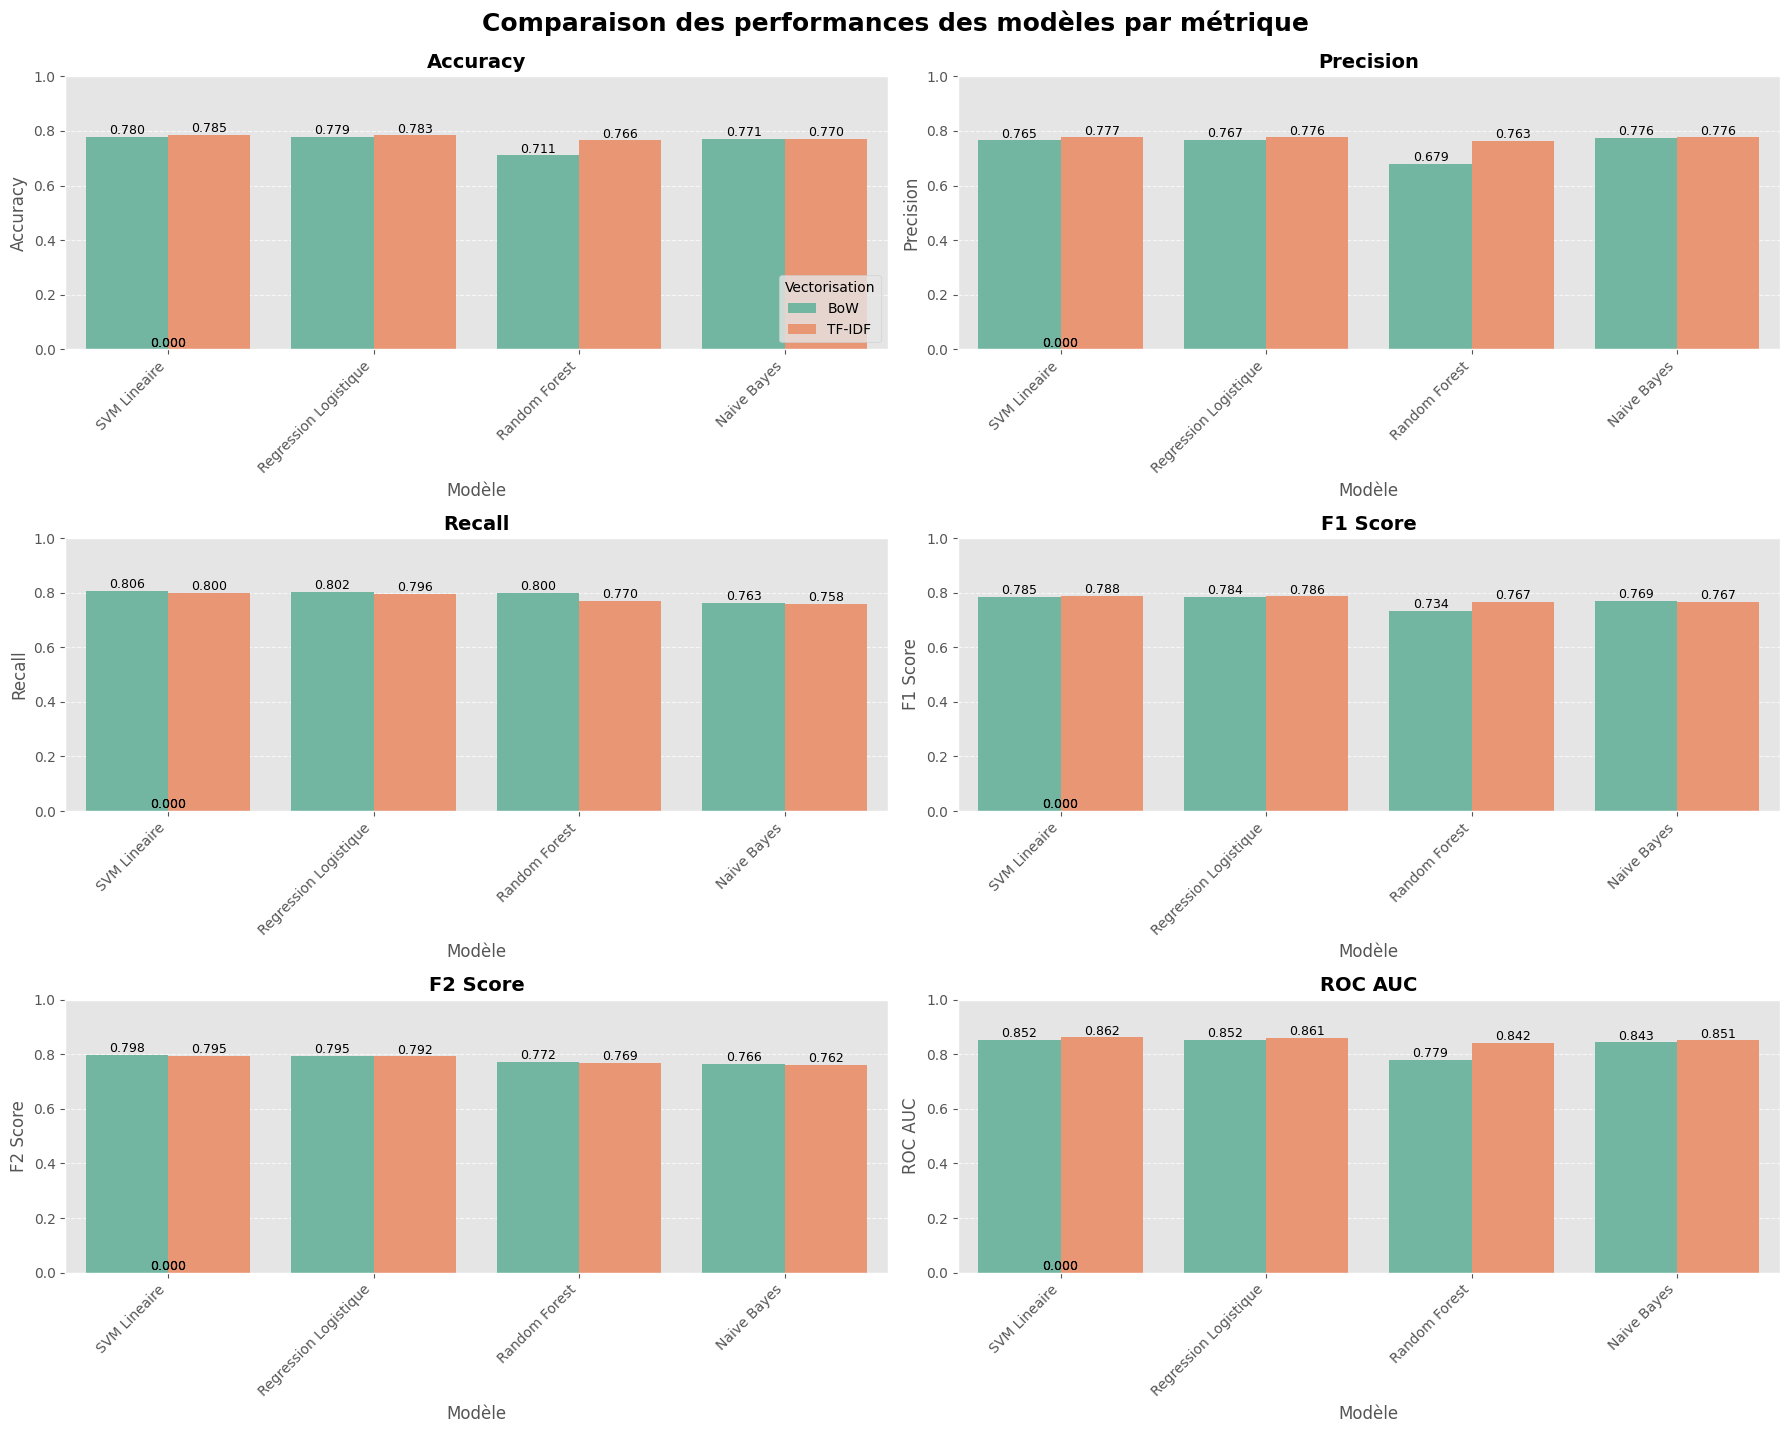

In [28]:
# Créer la visualisation
display_metrics_subplot(results_df)

### Identifier le meilleur modèle selon F2

In [29]:
# Identifier le meilleur modèle selon F2
best_model_row = results_df.loc[results_df['F2 Score'].idxmax()]
best_model_name = best_model_row['Modèle'].replace(" ", "_")
best_vectorizer = best_model_row['Vectorisation']

print(f"\nMeilleur modèle (selon F2): {best_model_row['Modèle']} avec {best_vectorizer}")
print(f"F1 Score: {best_model_row['F1 Score']:.4f}")
print(f"F2 Score: {best_model_row['F2 Score']:.4f}")
print(f"ROC AUC: {best_model_row['ROC AUC']:.4f}")
print(f"Meilleurs paramètres: {best_model_row['Meilleurs paramètres']}")
print(f"\nRun ID du meilleur modèle: {best_model_row['Run ID']}")


Meilleur modèle (selon F2): SVM Lineaire avec BoW
F1 Score: 0.7853
F2 Score: 0.7976
ROC AUC: 0.8517
Meilleurs paramètres: {'C': '0.01', 'dual': 'True', 'max_iter': '1000'}

Run ID du meilleur modèle: 82e7cbe6cb064cdba3d9fbff6cf2feb0


## Charger le meilleur modèle et son vectoriseur depuis MLflow

In [30]:
def load_and_save_best_model(run_id, folder_path="content/simple-model/best"):
    """
    Charge le meilleur modèle et son vectoriseur depuis MLflow et les sauvegarde localement
    
    Parameters:
    -----------
    run_id : str
        L'identifiant du run MLflow contenant le meilleur modèle
    folder_path : str, optional
        Le chemin où sauvegarder le modèle et le vectoriseur
        
    Returns:
    --------
    tuple
        (modèle chargé, vectoriseur chargé)
    """
    # Créer le dossier cible s'il n'existe pas
    try:
        os.makedirs(folder_path, exist_ok=True)
    except PermissionError:
        print(f"Erreur de permission pour le dossier {folder_path}")
        print("Tentative avec un dossier temporaire...")
        import tempfile
        temp_dir = tempfile.mkdtemp()
        print(f"Utilisation du dossier temporaire : {temp_dir}")
        folder_path = temp_dir
    
    # Créer un client MLflow
    client = MlflowClient()
    
    print(f"Chargement du modèle depuis le run {run_id}...")
    
    # Charger le modèle depuis MLflow
    best_model = mlflow.sklearn.load_model(f"runs:/{run_id}/model")
    
    print(f"Modèle chargé avec succès : {type(best_model).__name__}")
    
    # Récupérer les paramètres du run pour vérifier le type de vectoriseur
    run = client.get_run(run_id)
    vectorizer_type = run.data.params.get("vectorizer_type", "").lower()
    
    print(f"Type de vectoriseur utilisé dans ce run : {vectorizer_type}")
    
    # Récupérer les artefacts du run
    artifacts = client.list_artifacts(run_id)
    
    # Chercher le vectoriseur en privilégiant BoW ou CountVectorizer
    vectorizer_path = None
    
    # Afficher les artefacts disponibles
    print("Artefacts disponibles :")
    for artifact in artifacts:
        print(f"  - {artifact.path}")
    
    # Priorité 1: Chercher un vectoriseur correspondant au type attendu (BoW ou CountVectorizer)
    for artifact in artifacts:
        path_lower = artifact.path.lower()
        if "vectorizer" in path_lower and ("bow" in path_lower or "countvectorizer" in path_lower):
            vectorizer_path = artifact.path
            print(f"Vectoriseur de type BoW/CountVectorizer trouvé : {artifact.path}")
            break
    
    # Priorité 2: Chercher n'importe quel vectoriseur
    if not vectorizer_path:
        for artifact in artifacts:
            if "vectorizer" in artifact.path.lower():
                vectorizer_path = artifact.path
                print(f"Vectoriseur générique trouvé : {artifact.path}")
                break
    
    # Télécharger et charger le vectoriseur
    if vectorizer_path:
        local_path = client.download_artifacts(run_id, vectorizer_path)
        print(f"Vectoriseur téléchargé dans : {local_path}")
        
        # Charger le vectoriseur depuis le fichier local
        with open(local_path, "rb") as f:
            vectorizer = pickle.load(f)
        
        print(f"Vectoriseur chargé avec succès : {type(vectorizer).__name__}")
    else:
        print("Aucun fichier vectoriseur trouvé dans les artefacts, tentative de chargement direct...")
        
        # Tenter de charger le vectoriseur directement depuis MLflow
        try:
            vectorizer = mlflow.sklearn.load_model(f"runs:/{run_id}/vectorizer")
            print(f"Vectoriseur chargé directement depuis MLflow : {type(vectorizer).__name__}")
        except Exception as e:
            print(f"Erreur lors du chargement direct du vectoriseur : {e}")
            raise FileNotFoundError("Aucun vectoriseur trouvé dans les artefacts du run")
    
    # Sauvegarder le modèle et le vectoriseur localement avec leurs noms spécifiques
    model_name = type(best_model).__name__
    vectorizer_name = type(vectorizer).__name__
    model_save_path = os.path.join(folder_path, f"{model_name}_model.pkl")
    vectorizer_save_path = os.path.join(folder_path, f"{vectorizer_name}_vectorizer.pkl")
    
    # Sauvegarder le modèle
    with open(model_save_path, "wb") as f:
        pickle.dump(best_model, f)
    
    # Sauvegarder le vectoriseur
    with open(vectorizer_save_path, "wb") as f:
        pickle.dump(vectorizer, f)
    
    print(f"Modèle et vectoriseur sauvegardés avec succès dans {folder_path}")
    print(f"Chemins des fichiers :")
    print(f"  - Modèle : {os.path.abspath(model_save_path)}")
    print(f"  - Vectoriseur : {os.path.abspath(vectorizer_save_path)}")
    
    return best_model, vectorizer

In [32]:
# Charger et sauvegarder le meilleur modèle et son vectoriseur
best_model, vectorizer = load_and_save_best_model(run_id="82e7cbe6cb064cdba3d9fbff6cf2feb0")

Chargement du modèle depuis le run 82e7cbe6cb064cdba3d9fbff6cf2feb0...


Modèle chargé avec succès : LinearSVC
Type de vectoriseur utilisé dans ce run : bow
Artefacts disponibles :
  - confusion_matrix.png
  - cv_results.csv
  - cv_results_C.png
  - cv_results_dual.png
  - model
  - roc_curve.png
  - top_features.csv
  - top_negative_features.png
  - top_positive_features.png
  - vectorizer_BoW.pkl
Vectoriseur de type BoW/CountVectorizer trouvé : vectorizer_BoW.pkl


Vectoriseur téléchargé dans : /tmp/tmpj_ewmxck/vectorizer_BoW.pkl
Vectoriseur chargé avec succès : CountVectorizer
Modèle et vectoriseur sauvegardés avec succès dans content/simple-model/best
Chemins des fichiers :
  - Modèle : /home/david/projects/openclassrooms/projets/oc-ai-engineer-p07-analyse-sentiments-deep-learning/content/simple-model/best/LinearSVC_model.pkl
  - Vectoriseur : /home/david/projects/openclassrooms/projets/oc-ai-engineer-p07-analyse-sentiments-deep-learning/content/simple-model/best/CountVectorizer_vectorizer.pkl


## Fonction de prédiction pour l'API

Cette fonction constitue **le cœur de notre solution d'analyse de sentiment**. Elle prend **un tweet en entrée**, le prétraite, le vectorise et utilise notre modèle pour **prédire son sentiment**. Elle retourne un dictionnaire contenant le résultat (positif/négatif), un score de confiance et des métadonnées sur le modèle utilisé, **prêt à être exposé via l'API RESTful**.

In [33]:
def predict_sentiment(text, model=best_model, vect=vectorizer):
    """
    Fonction qui prend un texte en entrée et retourne la prédiction du sentiment
    Cette fonction pourra être utilisée dans l'API
    """
    # Prétraiter le texte
    processed_text = preprocess_tweet(text)
    
    # Vectoriser
    text_vectorized = vect.transform([processed_text])
    
    # Prédire
    prediction = model.predict(text_vectorized)[0]
    
    # Récupérer la probabilité si le modèle le permet
    if hasattr(model, 'predict_proba'):
        probas = model.predict_proba(text_vectorized)[0]
        confidence = probas[1] if prediction == 1 else probas[0]
    else:
        # Pour les modèles sans predict_proba, comme SVM
        decision = model.decision_function(text_vectorized)[0] if hasattr(model, 'decision_function') else 0
        confidence = abs(decision) / 2  # Normaliser d'une certaine façon
    
    return {
        'sentiment': 'positif' if prediction == 1 else 'négatif',
        'score': float(confidence),
        'model': best_model_name,
        'vectorizer': best_vectorizer
    }

## Test de la fonction de prédiction sur quelques exemples

Nous avons constitué un **ensemble diversifié de tweets tests** incluant différentes caractéristiques linguistiques des réseaux sociaux pour évaluer notre modèle de détection de sentiment. Les résultats sont présentés dans un **DataFrame** avec des indicateurs visuels (💚/❌) permettant d'identifier rapidement les prédictions et leur **niveau de confiance**, validant ainsi l'efficacité de notre solution pour **anticiper les bad buzz**.

In [34]:
# Liste améliorée de tweets pour tester le modèle
test_tweets_improved = [
    # Tweets positifs avec différentes caractéristiques
    "I absolutely love flying with @AirParadis! Their service is amazing and their staff is so helpful :) #bestairline #travel",
    "Just landed after a wonderful flight... The crew was totally awesome and the food was perfect!!! Can't wait to fly with them again :D",
    "OMG! You really have to try @AirParadis. Best. Flight. Ever. Their new seats are extremely comfortable. http://airparadis.com/newseats #travel #comfort",
    "We had a very pleasant experience with our flight today. The staff completely exceeded our expectations ;) #happy #AirParadis",
    "My first time flying business class and I'm absolutely amazed!!! The service is 100% worth it... @AirParadis never disappoints :)",
    
    # Tweets négatifs avec différentes caractéristiques
    "I hate how @AirParadis always delays their flights... This is the third time this month!!! :( #disappointed #travel",
    "The worst flight experience of my life? Definitely today with @AirParadis. Their customer service won't even respond to my complaints... #terrible",
    "Really @AirParadis??? Flight cancelled and no compensation??? That's how you treat your customers? SMH :(",
    "Our baggage was lost and nobody at @AirParadis seems to care! Don't they understand that we can't enjoy our vacation without our stuff??? http://badservice.com/complaint :-(",
    "Food was terrible, seats were uncomfortable, and the staff was not helpful at all... Never flying with @AirParadis again! #worstairline",
    
    # Tweets mixtes et nuancés
    "The flight was good but the food wasn't really what I expected... @AirParadis can do better! #mixedfeelings",
    "IDK what to think about my @AirParadis experience? The crew was nice but the flight was delayed for 2 hours... #confused",
    "My husband loved the flight but I didn't... Too bad they can't make everyone happy :-) #AirParadis",
    "TBH, @AirParadis has improved their service since last year! Not perfect yet, but they're trying... #progress",
    "We were so excited for our trip but then our flight got delayed... at least the staff was very apologetic and gave us free drinks! @AirParadis",
    
    # Tweets spécifiquement pour tester les caractéristiques spéciales
    "This is a tweet with many!!! exclamation!!! marks!!! to test how they affect sentiment analysis :)",
    "How does the model handle multiple??? question??? marks??? in a single tweet? @AirParadis",
    "Testing ellipses... many... many... ellipses... in... one... tweet... @AirParadis #test",
    "#many #hashtags #in #one #tweet #to #see #how #they #affect #the #analysis #AirParadis",
    "@mention1 @mention2 @mention3 @mention4 @mention5 multiple mentions in one tweet",
    "Multiple URLs in one tweet: http://example1.com http://example2.com http://example3.com @AirParadis",
    "Let's try all emoticons :) :( :D ;) :-) :-( :-D ;-) in a single tweet to see the impact"
]

In [35]:
def test_model_on_examples(model, vectorizer, test_tweets):
    """
    Teste le modèle sur une liste de tweets et retourne un DataFrame avec les résultats des prédictions.
    """

    results = {
        "positif": 0,
        "négatif": 0
    }
    
    # Créer un DataFrame pour stocker les résultats
    predictions_data = []
    
    for i, tweet in enumerate(test_tweets):
        result = predict_sentiment(tweet, model, vectorizer)
        
        # Ajouter l'emoji approprié pour le sentiment
        emoji = "💚" if result['sentiment'] == "positif" else "❌"
        
        # Ajouter les données au DataFrame
        predictions_data.append({
            "Tweet": tweet,
            "Sentiment": result['sentiment'],
            "Emoji": emoji,
            "Score de confiance": result['score'],
            "Index": i+1
        })
        
        # Comptage des résultats
        results[result['sentiment']] += 1
    
    # Créer le DataFrame
    df_predictions = pd.DataFrame(predictions_data)
    
    # Afficher un résumé
    print("\nTest du modèle sur les exemples:")
    print("="*50)
    print(f"Résumé: {len(test_tweets)} tweets analysés")
    print(f"Tweets positifs: {results['positif']} ({(results['positif']/len(test_tweets)*100):.1f}%)")
    print(f"Tweets négatifs: {results['négatif']} ({(results['négatif']/len(test_tweets)*100):.1f}%)")

    # Retourner le DataFrame
    return df_predictions

# Exemple d'utilisation:
if best_model is not None and vectorizer is not None:
    # Obtenir le DataFrame des prédictions
    df_results = test_model_on_examples(best_model, vectorizer, test_tweets_improved)    
    # Optionnel: sauvegarder les résultats dans un fichier CSV
    df_results.to_csv("content/simple-model/best/predictions_results.csv", index=False)


Test du modèle sur les exemples:
Résumé: 22 tweets analysés
Tweets positifs: 13 (59.1%)
Tweets négatifs: 9 (40.9%)


In [36]:
df_results

,Tweet,Sentiment,Emoji,Score de confiance,Index
0,I absolutely love flying with @AirParadis! The...,positif,💚,0.523166,1
1,Just landed after a wonderful flight... The cr...,positif,💚,0.683024,2
2,OMG! You really have to try @AirParadis. Best....,positif,💚,0.487842,3
3,We had a very pleasant experience with our fli...,positif,💚,0.275351,4
4,My first time flying business class and I'm ab...,positif,💚,0.271234,5
5,I hate how @AirParadis always delays their fli...,négatif,❌,0.386867,6
6,The worst flight experience of my life? Defini...,négatif,❌,0.408079,7
7,Really @AirParadis??? Flight cancelled and no ...,négatif,❌,0.351172,8
8,Our baggage was lost and nobody at @AirParadis...,négatif,❌,0.633144,9
9,"Food was terrible, seats were uncomfortable, a...",négatif,❌,0.391808,10


In [37]:
df_results.columns

Index(['Tweet', 'Sentiment', 'Emoji', 'Score de confiance', 'Index'], dtype='object')

## Conclusion de l'approche "Modèle Simple"

Nous avons développé plusieurs modèles classiques pour la détection de sentiment dans les tweets,
en utilisant une **optimisation des hyperparamètres via GridSearchCV** optimisée sur le **F2-score
pour privilégier le rappel (capacité à ne pas manquer de tweets négatifs)** :

1. Régression Logistique
2. SVM Linéaire
3. Random Forest
4. Naive Bayes

Chaque modèle a été testé avec deux types de vectorisation :
- Sac de mots (BoW)
- TF-IDF

Le meilleur modèle selon le F2-score est **SVM_Lineaire avec la vectorisation BoW** atteignant :
- **F2 Score de 0.7976**
- **F1 Score de 0.7853**
- **ROC AUC de 0.8517**

Les hyperparamètres optimaux trouvés pour ce modèle sont : **{'C': '0.01', 'dual': 'True', 'max_iter': '1000'}**

### Avantages du workflow implémenté :

1. **Focalisation sur le rappel avec F2-score** :
   - Réduit le risque de manquer des tweets négatifs (bad buzz potentiels)
   - Particulièrement adapté pour l'anticipation des problèmes de réputation

2. **Suivi complet des expériences avec MLflow** :
   - Tracking de toutes les métriques importantes
   - Sauvegarde des modèles et vectoriseurs
   - Visualisations des performances

3. **Optimisation systématique** :
   - Recherche sur grille des meilleurs hyperparamètres
   - Validation croisée pour éviter le surapprentissage
   - Comparaison rigoureuse des performances

4. **Prétraitement adapté aux tweets** :
   - Traitement spécifique des URLs, mentions et hashtags
   - Conservation des négations et autres éléments linguistiques importants
   - Features supplémentaires basées sur l'analyse des données

### Prochaines étapes :

1. **Développer le modèle sur mesure avancé** utilisant des réseaux de neurones et des word embeddings
2. **Tester l'approche avec BERT** pour comparer les performances
3. **Déployer le modèle via une API** pour le rendre accessible à d'autres applications
4. **Mettre en place le suivi MLOps** pour monitorer les performances du modèle en production

Le modèle actuel servira de référence (baseline) pour évaluer les améliorations apportées par 
les approches plus avancées.


## Explications détaillées

Le code complet intègre plusieurs pratiques MLOps avancées:

### 1. Optimisation des hyperparamètres avec GridSearchCV

J'ai implémenté GridSearchCV pour chaque combinaison de modèle et vectoriseur. Cela permet d'explorer systématiquement l'espace des hyperparamètres pour trouver la configuration optimale. Pour chaque modèle, j'ai défini une grille de paramètres pertinents:

- **Régression Logistique**: différentes valeurs de régularisation (C), types de solveurs
- **SVM**: différentes valeurs de C, options de dualité
- **Random Forest**: nombre d'arbres, profondeur maximale, critères de division
- **Naive Bayes**: différentes valeurs pour le paramètre de lissage alpha

L'optimisation est effectuée avec validation croisée à 5 plis (5-fold) pour garantir la robustesse des résultats.

### 2. Tracking complet avec MLflow

Pour chaque expérience, j'enregistre dans MLflow:

- **Paramètres**: tous les hyperparamètres utilisés, y compris les meilleurs trouvés par GridSearchCV
- **Métriques**: accuracy, precision, recall, F1 score, ROC AUC, temps d'entraînement
- **Artifacts**: 
  - Le modèle optimisé avec sa signature d'entrée/sortie
  - Le vectoriseur utilisé (nouveauté demandée)
  - La matrice de confusion et la courbe ROC
  - Les résultats détaillés de la validation croisée
  - Les features les plus importantes (pour les modèles qui le permettent)
  - Des graphiques d'analyse de l'influence des hyperparamètres

### 3. Sauvegarde et utilisation du meilleur modèle

J'ai implémenté une méthode pour:

1. Identifier le meilleur modèle dans l'historique MLflow
2. Le récupérer avec son vectoriseur
3. Sauvegarder les deux dans un dossier local spécifié ("content/simple-model/best")
4. Créer une fonction de prédiction prête pour l'API

### 4. Visualisations avancées

Pour faciliter l'analyse:

- Matrices de confusion pour chaque modèle
- Courbes ROC avec AUC calculé
- Graphiques des features les plus importantes
- Graphiques d'évolution des scores en fonction des hyperparamètres